## Imports

In [19]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
import scipy.constants as c
phc = c.physical_constants
import sys
from scipy.interpolate import interp1d

DEG_TO_RAD = np.pi / 180
RAD_TO_DEG = 180 / np.pi

sys.path.append('/home/excalibur/pCloudDrive/Informatik/Python/')
from self_written_functions import eprint

sys.path.append('/home/excalibur/Dropbox/Bachelor')
from main_class import *

%matplotlib inline
plot_color = 'grey'
mpl.rc('figure', figsize=[13, 9])
mpl.rc('axes', edgecolor=plot_color, labelcolor=plot_color, grid=True, labelsize=25)
mpl.rc('xtick', color=plot_color, labelsize=16)
mpl.rc('ytick', color=plot_color, labelsize=16)

## Creating Interpolations and Functions

### Photon Energy

In [2]:
def energy_photon(lambda_):
    """
       lamda_ [nm]
       returns [J]
    """
    return phc['Planck constant'][0] * phc['speed of light in vacuum'][0] / (lambda_ * 10**-9) 

### Filter 450nm

In [3]:
filter_data = np.genfromtxt('../spectren/450nm/450nm_trans_data_calc.csv')

filter_inter = interp1d(filter_data.T[0], filter_data.T[1], kind='cubic')

### Diode Response Function

In [4]:
response_data = np.genfromtxt('../spectren/PD-calibration.txt')

response_inter = interp1d(response_data.T[0], response_data.T[1], kind='cubic')  # A / W

### Emission Spectrum + Normalization

In [5]:
emission_data = np.genfromtxt('../spectren/New_spectrum_excited_at_380nm.txt')

emission_inter = sc.interpolate.UnivariateSpline(emission_data.T[0], emission_data.T[1])

In [6]:
# normalizing in range 380nm - 540nm
# for outer range value close to 0, but large errors
borders = (380, 540)
norm = emission_inter.integral(*borders)

def emission_inter_normalized(lambda_):
    return emission_inter(lambda_) / norm
# integral over S_WLS * dx = 1 -> S_WLS is "probability density function" (dN / dlambda)

### Current

In [7]:
current_data = np.genfromtxt('run85_minus_run86_data.csv')
current_inter = interp1d(current_data.T[0], current_data.T[1], kind='cubic')

## Integrating Current

### Borders

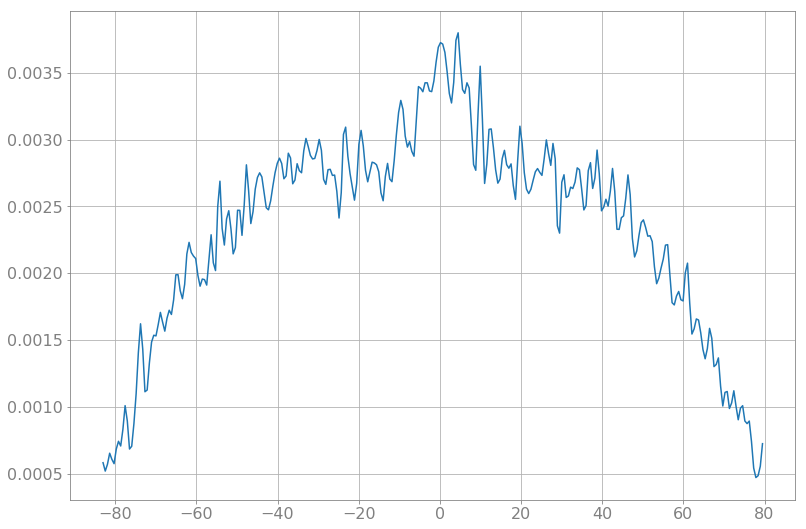

In [20]:
x = np.linspace(-83, 79.5, 300)
plt.plot(x, current_inter(x));

In [9]:
borders = (0, -83 * DEG_TO_RAD)  # choosing left side

### Integration

In [10]:
detector_distance = 7.5  # distance to detector
detector_window = 0.3  # diameter of detector window
detector_radius = detector_window / 2
detector_solid_angle = np.pi * detector_radius**2 / detector_distance**2

In [11]:
def integrand(theta):
    """
        theta [rad]
        returns: I_d_omega [nA / sr]
    """
    
    return current_inter(theta * RAD_TO_DEG) / detector_solid_angle * np.sin(theta) 

In [12]:
integral = sc.integrate.quad(integrand, borders[0], borders[1])
integral

/home/excalibur/miniconda3/envs/main/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(1.4301069175115617, 0.00010273298593648133)

In [13]:
def e_captured(n1: float, n2: float):
    return 1 - 2 * np.sin(np.arcsin(n2 / n1) / 2)**2

In [14]:
I_total = integral[0] * 2 * np.pi * 2 / e_captured(1.5, 1)  # nA
I_total

24.11096673863631

## Current to n_photons

In [15]:
borders_2 = (380, 540)  # nm

In [16]:
def integrand_2(lambda_):
    return emission_inter_normalized(lambda_) * response_inter(lambda_) * energy_photon(lambda_) * filter_inter(lambda_)

In [17]:
denominator = sc.integrate.quad(integrand_2, borders_2[0], borders_2[1])[0]
denominator

1.7576879592146824e-20

In [18]:
R_out = I_total * 10**-9 / denominator  # n_photons / s
eprint(R_out)

1.371743e+12
